# Example: JUSTICE - IAM Simulation Run

In [1]:
import pandas as pd
import numpy as np

from src.data_loader import DataLoader
from src.enumerations import *
from src.model_time import TimeHorizon
from src.model import JUSTICE

### Setting Some Dummy Policy Levers

#### Lever: Fixed Savings rate

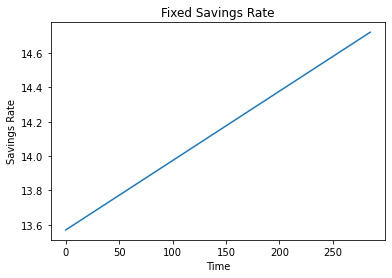

(57, 286)


In [2]:
# Load the data
data_loader = DataLoader()

# Instantiate the TimeHorizon class
time_horizon = TimeHorizon(start_year=2015, end_year=2300, data_timestep=5, timestep=1)

#Create a fixed savings rate
fixed_savings_rate = np.copy(data_loader.SAVING_RATE_INIT_ARRAY).reshape(-1, 1)
#fixed_savings_rate Validated with RICE50 for timestep 1 and 5

set_year = time_horizon.model_time_horizon
#economy.get_optimal_long_run_savings_rate() = 0.2582781457 #This needs the economy module to be instantiated

for i, years in enumerate(set_year):
    
    t = i+1 #index starts at 0, so add 1 to get the year

    if t != 1: # no need to repeat for the first year

        next_rate = data_loader.SAVING_RATE_INIT_ARRAY + (0.2582781457  - data_loader.SAVING_RATE_INIT_ARRAY)*((t - 1)/(len(set_year) - 1))
        # append to the fixed savings rate array for each year
        fixed_savings_rate = np.column_stack((fixed_savings_rate, next_rate))

from matplotlib import pyplot as plt
plt.plot(np.sum(fixed_savings_rate, axis=0))
plt.title("Fixed Savings Rate")
plt.xlabel("Time")
plt.ylabel("Savings Rate")
plt.show()
print(fixed_savings_rate.shape)

In [3]:
# Save fixed savings rate as a csv file using pandas

# df = pd.DataFrame(fixed_savings_rate)
# df.to_csv('config/savings_rate_fixed.csv', index=False)
# Find the minimum savings rate
print("Minimum savings rate: ", np.min(fixed_savings_rate))

Minimum savings rate:  0.09317


#### Lever: Linear Emissions Control Rate

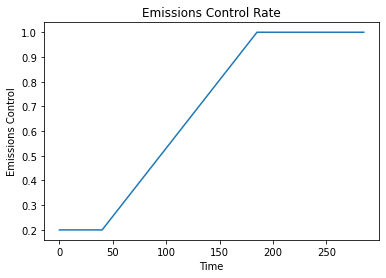

In [4]:
#emissions control rate borrowed from emissions module

#Variables to be changed/deleted later
miu_initial = 0.0
min_miu = 0.2 #0.0 #1.0
min_miu_year = 2055 #9-original #8 in this model  # 2060
max_miu = 1.0 #1.2
max_miu_year = 2200 #38-original #37 in this model #2205

t_min_miu = time_horizon.year_to_timestep(min_miu_year, timestep=1)
t_max_miu = time_horizon.year_to_timestep(max_miu_year, timestep=1)

#Initialize emissions control rate
emissions_control_rate = np.zeros((len(data_loader.REGION_LIST), len(time_horizon.model_time_horizon)))

for t in range(len(time_horizon.model_time_horizon)):
    
    if t < t_min_miu:       # Before time of transition
        emissions_control_rate[:,t] = min_miu
    elif t <= t_max_miu:   # Transition
        # During the transition
        emissions_control_rate[:, t] = min_miu + (max_miu - min_miu) * (t - t_min_miu)/(t_max_miu - t_min_miu)
    else:                   # After the transition
        emissions_control_rate[:, t] = max_miu


from matplotlib import pyplot as plt
plt.plot(emissions_control_rate[0, :])
plt.title("Emissions Control Rate")
plt.xlabel("Time")
plt.ylabel("Emissions Control")
plt.show()

In [5]:
# Save emissions control rate as a csv file using pandas

df = pd.DataFrame(emissions_control_rate)
df.to_csv('config/emissions_control_rate_linear.csv', index=False)

## 1. JUSTICE Initialisation

In [6]:
# Get list of Scenarios from Enum

for idx, scenarios in enumerate(list(Scenario.__members__.keys())):
    print(idx, scenarios)

0 SSP119
1 SSP126
2 SSP245
3 SSP370
4 SSP434
5 SSP460
6 SSP534
7 SSP585


In [7]:
scenarios = 7
model = JUSTICE(
        
        start_year = 2015,
        end_year = 2300,
        timestep = 1,
        scenario =scenarios,
        economy_type=Economy.NEOCLASSICAL,
        damage_function_type=DamageFunction.KALKUHL,
        abatement_type=Abatement.ENERDATA,
    )

## 2. Run

In [8]:
model.run(savings_rate = fixed_savings_rate, emissions_control_rate = emissions_control_rate)

## 3. Evaluate - SWF - and Generated Output Datasets

In [9]:
datasets = model.evaluate(welfare_function=WelfareFunction.UTILITARIAN, elasticity_of_marginal_utility_of_consumption = 1.45, pure_rate_of_social_time_preference = 0.015, inequality_aversion = 0.5)

print(model.get_outcome_names())

(57, 286, 1001)
discount_rate.shape (57, 286, 1)
dict_keys(['net_economic_output', 'consumption', 'consumption_per_capita', 'emissions', 'regional_temperature', 'global_temperature', 'economic_damage', 'abatement_cost', 'carbon_price', 'disentangled_utility', 'welfare_utilitarian'])


In [10]:
net_output = datasets['net_economic_output']
consumption = datasets['consumption'] #(57, 286, 1001)
cpc = datasets['consumption_per_capita'] #(57, 286, 1001)
emis = datasets['emissions'] #(57, 286, 1001)
reg_temp = datasets['regional_temperature']
temp = datasets['global_temperature'] # (286, 1001)
damages = datasets['economic_damage'] #(57, 286, 1001)
abatecost = datasets['abatement_cost'] #(57, 286, 1001)
dis_util = datasets['disentangled_utility'] #(57, 286, 1001)
util = datasets['welfare_utilitarian'] # (286, 1001)


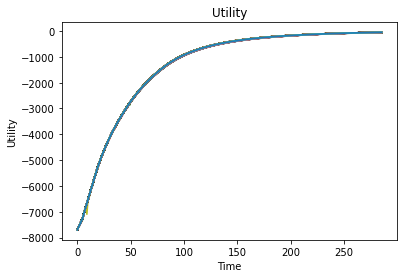

In [ ]:
# Assuming U, E, and C are your utility, emission, and consumption 3D numpy arrays...

# Prepare zero-filled 3D arrays for storing the results of gradient operations
# eq_E_m = np.zeros_like(cpc)
# eq_cc_m = np.zeros_like(cpc)

# # Calculate derivatives 
# eq_E_m = np.diff(dis_util, axis=1) / np.diff(emis, axis=1)
# eq_cc_m = np.diff(dis_util, axis=1) / np.diff(consumption, axis=1)

# # # Perform the operations slice by slice in a loop
# for i in range(cpc.shape[2]):
#     eq_E_m[:, :, i] = np.gradient(dis_util[:, :, i], emis[:, :, i], axis=1, edge_order=2)
#     eq_cc_m[:, :, i] = np.gradient(dis_util[:, :, i], consumption[:, :, i], axis=1, edge_order=2)

# # Calculate SCC
# SCC = -1000 * eq_E_m / eq_cc_m

# Sum up all the regions resulting in a 2D array (time, scenarios) for each variable
# dis_util_sum = np.sum(dis_util, axis=0)
# emis_sum = np.sum(emis, axis=0)
# cpc_sum = np.sum(cpc, axis=0)

# # Create zero-filled 2D arrays for storing the results of gradient operations
# eq_E_m = np.zeros_like(dis_util_sum)
# eq_cc_m = np.zeros_like(dis_util_sum)

# # Compute the derivatives for each scenario over time using np.gradient
# for i in range(dis_util_sum.shape[1]):  # Loop over scenarios
#     eq_E_m[:, i] = np.gradient(dis_util_sum[:, i], emis_sum[:, i], edge_order=2)
#     eq_cc_m[:, i] = np.gradient(dis_util_sum[:, i], cpc_sum[:, i], edge_order=2)

# # Calculate SCC
# SCC = -1000 * eq_E_m / eq_cc_m

In [ ]:
testdf = dis_util[:,:,0]

# Sum the testdf for all regions
#testdf = np.sum(testdf, axis=0)

In [ ]:
#damagedf = damages[:,:,0]
# time_horizon.model_time_horizon

## 4. Visualize

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create list of all the data arrays
data_list = [net_output, cpc, emis, reg_temp, damages, abatecost]
titles = ['Net Economic Output', 'Consumption per Capita', 'Emissions', 'Regional Temperature', 'Economic Damages', 'Abatement Cost']

region_index = 0

# Create a figure with 2 rows and 3 columns
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the axs array to iterate over it
axs = axs.flatten()

# Iterate over the data arrays and plot them
for i, data in enumerate(data_list):
    # Select the region based on region_index
    region_data = data[region_index, :, :]
    
    # Create a line plot for each scenario
    for j in range(region_data.shape[1]):
        sns.lineplot(x=time_horizon.model_time_horizon, y=region_data[:, j], ax=axs[i])
    
    # Set the title and axis labels
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel('Value')
    
# Remove the unused subplots
for i in range(len(data_list), len(axs)):
    fig.delaxes(axs[i])

# Adjust the layout and spacing
fig.tight_layout()
plt.subplots_adjust(hspace=0.5)





## Run All Scenarios

In [ ]:
# Create a dictionary to store the data for each scenario
scenario_data = {}


for idx, scenarios in enumerate(list(Scenario)):
    print(idx, scenarios)
    
    # Initialize the model
    model = JUSTICE(
        
        start_year = 2015,
        end_year = 2300,
        timestep = 1,
        scenario =scenarios,
        economy_type=Economy.NEOCLASSICAL,
        damage_function_type=DamageFunction.KALKUHL,
        abatement_type=Abatement.ENERDATA,
    )
    
    # Run the model
    model.run(savings_rate = fixed_savings_rate, emissions_control_rate = emissions_control_rate)

    # Evaluate the model
    scenario_data[scenarios] = model.evaluate(welfare_function=WelfareFunction.UTILITARIAN)


## EMA Workbench Tests

In [1]:
from analysis.analyzer import perform_exploratory_analysis

In [2]:
perform_exploratory_analysis(number_of_experiments=1)

[MainProcess/INFO] performing 1 scenarios * 2 policies * 1 model(s) = 2 experiments
100%|████████████████████████████████████████████| 2/2 [00:33<00:00, 16.60s/it]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] results saved successfully to /Users/palokbiswas/Desktop/pollockdevis_git/JUSTICE/data/output/results_open_exploration_1


In [ ]:
# from src.util.EMA_model_wrapper import model_wrapper
# from ema_workbench import Model, RealParameter

# sr_levers = []
# ecr_levers = []
# for i in range(57):
#     for j in range(286):
#         sr_levers.append(RealParameter(f"savings_rate {i} {j}", 0.05, 0.5))
#         ecr_levers.append(
#             RealParameter(f"emissions_control_rate {i} {j}", 0.00, 1.0)
#         )
# model_wrapper(ssp_rcp_scenario=0, elasticity_of_marginal_utility_of_consumption = 1.45, pure_rate_of_social_time_preference = 0.015, inequality_aversion = 0.5, n_regions=57, n_timesteps=286, savings_rate = sr_levers, emissions_control_rate = ecr_levers)

